<H3> Astrometry quality checks </H3>

The idea is to compute the distribution of the angular distances between matched sources from a set of exposures covering the same area. We arbitrarily take the first exposure as a reference.

The angular distance is computed:
<OL>
<LI> using the source coordinates associated to the "src" catalog, thus corresponding to the standard astrometric solution (fit using an external reference catalog only)</LI>
<LI> using the updated WCS from the simultaneous astrometry fit</LI>
</OL>

In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import math

# List of visits to be considered
visits = [845346, 849375, 852894, 906675, 996234]
#visits = [849375, 850587]

# Reference visit
ref = 845346

# Tract
tract = 1

# List of CCD to be considered (source calatlogs will be concateneted)
#ccd = [12, 13, 14, 21, 22, 23]
ccd = [0, 1, 7, 8, 27, 28, 34, 35]
#ccd = [21, 22, 27, 28]
#ccd = [14]

filter = 'r'

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", "base_CircularApertureFlux_4_5_flag", "base_SdssCentroid_flag", 
         "base_SdssShape_flag"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output/coadd_r_dir")

for indx, c in enumerate(ccd) :
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    oldSrc = butler.get('src', dataid, immediate=True)
    print c, len(oldSrc)
    if indx == 0 :
        # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
        oldSchema = oldSrc.getSchema()
        mapper = afwTable.SchemaMapper(oldSchema)
        mapper.addMinimalSchema(oldSchema)
        newSchema = mapper.getOutputSchema()
        newSchema.addField("ccd", type=int, doc="CCD number")
        
        #create the new extented source catalog 
        srcRef = afwTable.SourceCatalog(newSchema)
    
    # create temporary catalog
    tmpCat = afwTable.SourceCatalog(srcRef.table)
    tmpCat.extend(oldSrc, mapper=mapper)
    # fill in the ccd information in numpy mode in order to be efficient
    tmpCat['ccd'][:] = c
    # append the temporary catalog to the extended source catalog    
    srcRef.extend(tmpCat, deep=False)

print "Ref...", len(srcRef)

mag = []
oldDist = []
newDist = []
for v in visits :
    if v == ref :
        continue
    for indx, c in enumerate(ccd) :
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        oldSrc = butler.get('src', dataid, immediate=True)
        if indx == 0 :
            # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
            oldSchema = oldSrc.getSchema()
            mapper = afwTable.SchemaMapper(oldSchema)
            mapper.addMinimalSchema(oldSchema)
            newSchema = mapper.getOutputSchema()
            newSchema.addField("ccd", type=int, doc="CCD number")
        
            #create the new extented source catalog 
            srcVis = afwTable.SourceCatalog(newSchema)
    
        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(srcRef.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = c
        # append the temporary catalog to the extended source catalog    
        srcVis.extend(tmpCat, deep=False)
        
    print "Visit :", v, "nbr of sources :", len(srcVis)
    
    match = afwTable.matchRaDec(srcRef, srcVis, afwGeom.Angle(1./3600., afwGeom.degrees))
    print "Visit :", v, len(match), "matches found"
    
    schemaRef = srcRef.getSchema()
    schemaVis = srcVis.getSchema()
    flagKeyRef = []
    flagKeyVis = []
    for f in Flags :
        keyRef = schemaRef[f].asKey()
        flagKeyRef.append(keyRef)
        keyVis = schemaVis[f].asKey()
        flagKeyVis.append(keyVis)
        
    extendKey = schemaRef["base_ClassificationExtendedness_value"].asKey()
    fluxKey = schemaRef["base_CircularApertureFlux_4_5_flux"].asKey()
    fluxSigmaKey = schemaRef["base_CircularApertureFlux_4_5_fluxSigma"].asKey()
    ccdKeyRef = schemaRef["ccd"].asKey()
    ccdKeyVis = schemaVis["ccd"].asKey()
    
    for m in match :
        mRef = m.first
        mVis = m.second
        
        for f in flagKeyRef :
            if mRef.get(f) :
                continue
        for f in flagKeyVis :
            if mVis.get(f) :
                continue
        
        # cleanup the reference sources in order to keep only decent star-like objects
        if mRef.get(extendKey) >= 0.5 :
            continue
        
        ang = afwGeom.radToMas(m.distance)
        
        # retrieve the CCD corresponding to the reference source
        ccdRef = mRef.get(ccdKeyRef)
        ccdVis = mVis.get(ccdKeyVis)
        
        # retrieve the calibration object associated to the CCDs
        didRef = {'visit':ref, 'filter':filter, 'ccd':ccdRef}
        didRef2 = {'visit':ref, 'filter':filter, 'ccd':ccdRef, 'tract':tract}
        mdRef = butler.get("calexp_md", didRef, immediate=True)
        calib = afwImage.Calib(mdRef)
        # compute magnitude
        flux = mRef.get(fluxKey)
        fluxSigma = mRef.get(fluxSigmaKey)
        if flux /fluxSigma < 5 :
            continue
        if flux > 0. :
            refMag = calib.getMagnitude(flux)
        else :
            continue
        if refMag < 16.5 :
            continue
            
        footprint = mVis.getFootprint()
        if footprint is not None and len(footprint.getPeaks()) > 1 :
            continue
        
        # retrieve the improved wcs and update the coordinate accordingly
        oldWcsRef = afwImage.TanWcs.cast(afwImage.makeWcs(mdRef))
        oldCoordRef = mRef.getCoord()
        pixelsRef = oldWcsRef.skyToPixel(oldCoordRef.getRa(), oldCoordRef.getDec())
        
        newWcsRefCont = butler.get('wcs', didRef2, immediate=True)
        newWcsRef = afwImage.TanWcs.cast(newWcsRefCont.getWcs())
        newCoordRef = newWcsRef.pixelToSky(pixelsRef).toIcrs()
        
        didVis = {'visit':v, 'filter':filter, 'ccd':ccdVis}
        didVis2 = {'visit':v, 'filter':filter, 'ccd':ccdVis, 'tract':tract}
        mdVis = butler.get("calexp_md", didVis, immediate=True)
        oldWcsVis = afwImage.TanWcs.cast(afwImage.makeWcs(mdVis))
        oldCoordVis = mVis.getCoord()
        pixelsVis = oldWcsVis.skyToPixel(oldCoordVis.getRa(), oldCoordVis.getDec())
        newWcsVisCont = butler.get('wcs', didVis2, immediate=True)
        newWcsVis = afwImage.TanWcs.cast(newWcsVisCont.getWcs())
        newCoordVis = newWcsVis.pixelToSky(pixelsVis).toIcrs()
        
        newAngle = 1000.0*newCoordRef.angularSeparation(newCoordVis).asArcseconds()       
                                    
        mag.append(refMag)
        oldDist.append(ang)
        newDist.append(newAngle)
        
        if refMag<20 and newAngle>400 :
            print v, newAngle, refMag, ccdRef, ccdVis, mRef.getCoord(), newCoordVis

0 1912
1 2029
7 2138
8 2248
27 1902
28 1930
34 1964
35 2014
Ref... 16137
Visit : 849375 nbr of sources : 9377
Visit : 849375 7755 matches found
Visit : 852894 nbr of sources : 13643
Visit : 852894 9703 matches found
852894 482.040406049 18.8212207352 1 1 IcrsCoord(215.4445806, 53.1693993) IcrsCoord(215.4446072, 53.1695231)
Visit : 906675 nbr of sources : 15331
Visit : 906675 10472 matches found
906675 489.743445053 18.8212207352 1 1 IcrsCoord(215.4445806, 53.1693993) IcrsCoord(215.4445900, 53.1695267)
Visit : 996234 nbr of sources : 12338
Visit : 996234 9031 matches found
996234 504.137249231 18.8212207352 1 1 IcrsCoord(215.4445806, 53.1693993) IcrsCoord(215.4445666, 53.1695313)


### Plot results for the standard astrometric solution (fit source coordinates to an external reference catalog only)

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


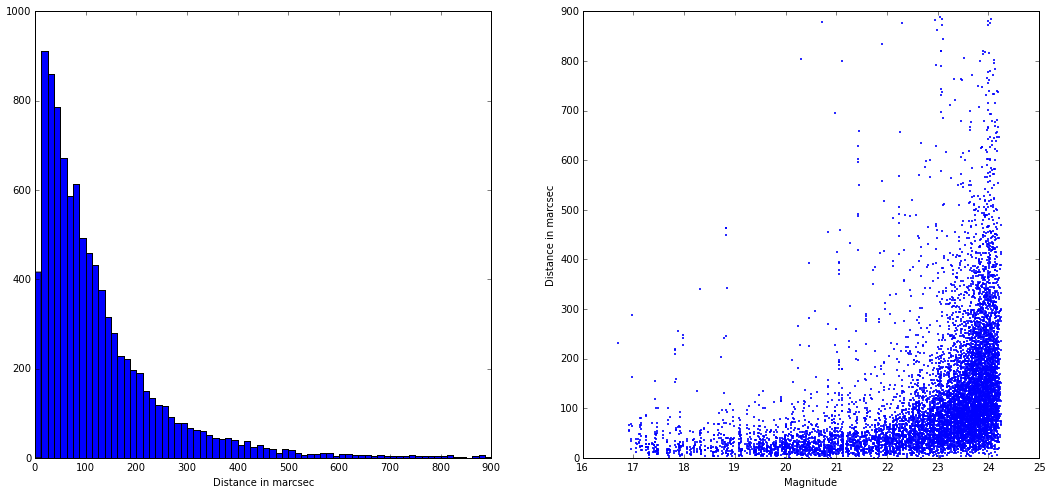

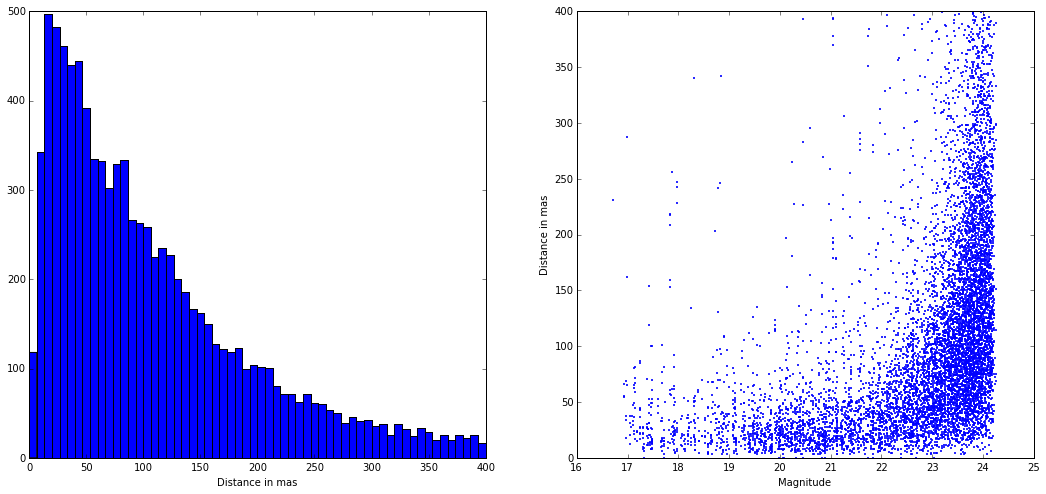

Median value of the astrometric scatter : 86.5529430187 mas


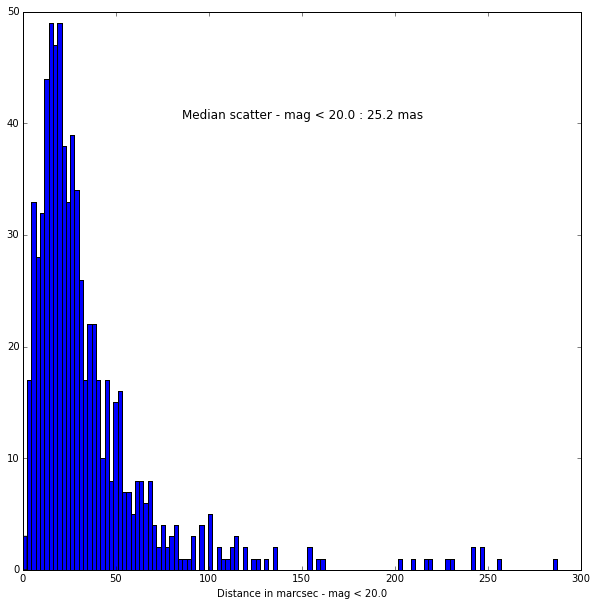

Median scatter - mag < 20.0 : 25.2 mas


In [2]:

%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18,
                                                 8))
ax0.hist(oldDist, bins=80)
ax1.scatter(mag, oldDist, s=1, color='b')
ax0.set_xlim([0., 900.])
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist,bins=150)
ax0.set_xlim([0.,400.])
ax1.scatter(mag, oldDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(oldDist), "mas"

magLim = 20
idxs = np.where(np.asarray(mag) < magLim)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(oldDist)[idxs], bins=200)
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_xlim([0,300])
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])),x=0.5, y=0.8)
plt.show()

print "Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs]))

### Plot results for astrometric solution from the simultaneous fit

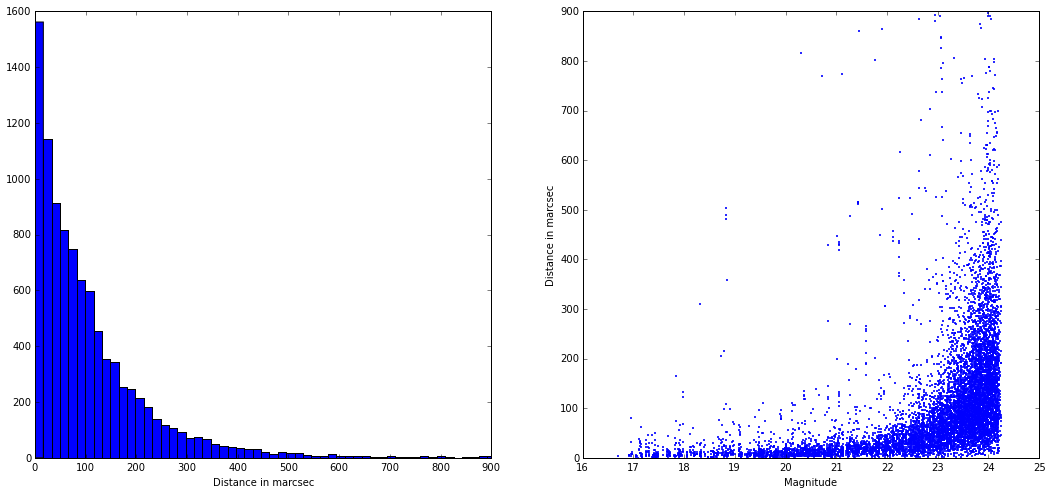

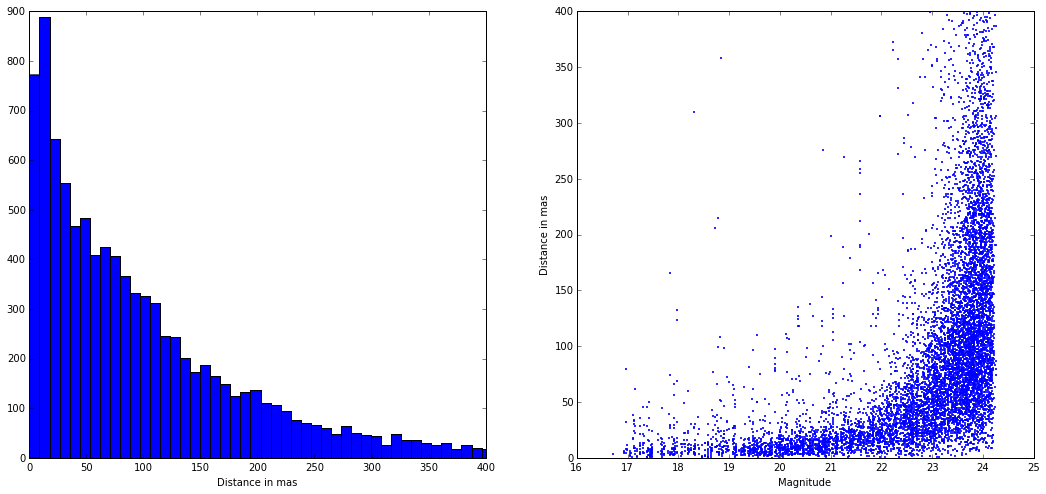

Median value of the astrometric scatter : 74.2910929665 mas


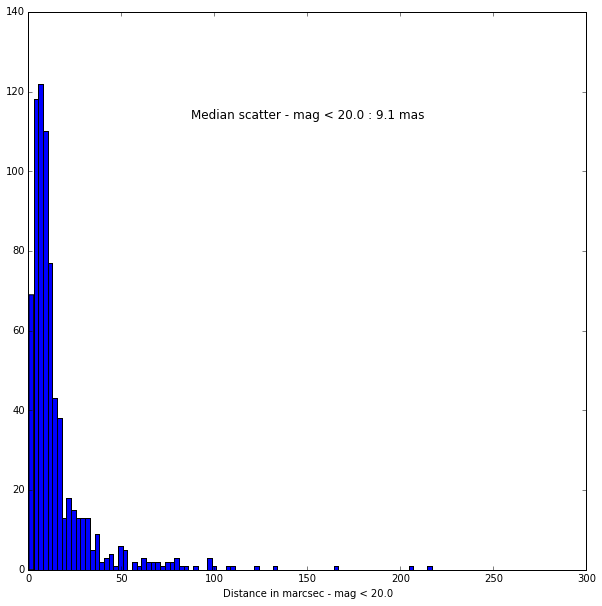

Astrometric scatter (median) - mag < 20.0 : 9.1 mas


In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist, bins=80)
ax1.scatter(mag, newDist, s=1, color='b')
ax0.set_xlim([0., 900.])
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist,bins=150)
ax0.set_xlim([0.,400.])
ax1.scatter(mag, newDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(newDist), "mas"

magLim = 20
idxs = np.where(np.asarray(mag) < magLim)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs], bins=200)
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_xlim([0,300])
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs])),x=0.5, y=0.8)
plt.show()

print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs]))

In [7]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom

dataid = {'visit':806305, 'filter':'r', 'ccd':10}
dataid2 = {'visit':806306, 'filter':'r', 'ccd':10, 'tract':1 }
#butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output/coadd_r_dir")
butler = dafPersist.Butler("/home/boutigny/CFHT/cluster/output/coadd_dir")

exp = butler.get('calexp', dataid2, immediate=True)
wcsCont = butler.get('wcs', dataid2, immediate=True)
newWcs = afwImage.TanWcs.cast(wcsCont.getWcs())
src = butler.get('src', dataid, immediate=True)

md = butler.get("calexp_md",dataid, immediate=True)
oldWcs = afwImage.TanWcs.cast(afwImage.makeWcs(md))

oldCoord = src[10].getCoord()
print oldCoord.getRa(), oldCoord.getDec()
oldRa = src[10].getRa()
oldDec = src[10].getDec()
print "old Coord", oldCoord

pixels = oldWcs.skyToPixel(oldCoord)
cc = oldWcs.pixelToSky(pixels).toIcrs()
print "Coord with reverse transformation - old WCS", cc
print "pixels with old wcs", pixels
newCoord = newWcs.pixelToSky(pixels).toIcrs()
newPixels = newWcs.skyToPixel(newCoord)
print "pixels with new wcs", newPixels
print newCoord
print

point = afwGeom.Point2D(100., 200.)
newCoord = newWcs.pixelToSky(point)
pointCheck = newWcs.skyToPixel(newCoord)

print "Verif new wcs - Point", point, "should be equal to ", pointCheck

point = afwGeom.Point2D(100., 200.)
oldCoord = oldWcs.pixelToSky(point)
pointCheck = oldWcs.skyToPixel(oldCoord)

print "Verif old wcs - Point", point, "should be equal to ", pointCheck

4.55689 rad 0.563233 rad
old Coord IcrsCoord(261.0908068, 32.2708863)
Coord with reverse transformation - old WCS IcrsCoord(261.0908068, 32.2708863)
pixels with old wcs (282, 31)
pixels with new wcs (282, 31)
IcrsCoord(261.0907890, 32.2723148)

Verif new wcs - Point (100, 200) should be equal to  (100, 200)
Verif old wcs - Point (100, 200) should be equal to  (100, 200)


In [10]:
print src.getSchema().getOrderedNames()
print src[10].get("coord_ra"), src[10].get("coord_dec")
print dir(src[10])

('id', 'coord_ra', 'coord_dec', 'parent', 'flags_negative', 'base_GaussianCentroid_x', 'base_GaussianCentroid_y', 'base_GaussianCentroid_flag', 'base_GaussianCentroid_flag_noPeak', 'base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts', 'base_NaiveCentroid_flag_edge', 'base_SdssCentroid_x', 'base_SdssCentroid_y', 'base_SdssCentroid_xSigma', 'base_SdssCentroid_ySigma', 'base_SdssCentroid_flag', 'base_SdssCentroid_flag_edge', 'base_SdssCentroid_flag_noSecondDerivative', 'base_SdssCentroid_flag_almostNoSecondDerivative', 'base_SdssCentroid_flag_notAtMaximum', 'base_SdssShape_xx', 'base_SdssShape_yy', 'base_SdssShape_xy', 'base_SdssShape_xxSigma', 'base_SdssShape_yySigma', 'base_SdssShape_xySigma', 'base_SdssShape_x', 'base_SdssShape_y', 'base_SdssShape_flux', 'base_SdssShape_fluxSigma', 'base_SdssShape_flux_xx_Cov', 'base_SdssShape_flux_yy_Cov', 'base_SdssShape_flux_xy_Cov', 'base_SdssShape_flag', 'base_SdssShape_flag_unweightedBad', 